# Evaluating Embeddings Generated for Concepts

In [41]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from Scripts.utils import ReadCSV

## Precision @k and MRR for embeddings
Precision_@k $:= \cfrac{\text{Number of Relevant Items in the top \textbf{K} results}}{k}$<br>
Recall_@k $:= \cfrac{\text{Number of Relevant Items in the top \textbf{K} results}}{\text{Number of Relevant Items}}$<br>
MMR $:= \frac{1}{|Q|} \underset{i=1}{\overset{|Q|}{\sum}} \frac{1}{\text{rank}_i}$

In [2]:
def precision_at_k(scores, relevant_items, k:int=2):
    return len([el for el in np.argsort(scores)[::-1][:k] if el in relevant_items])/ k

def recall_at_k(scores, relevant_items, k:int=2):
    return len([el for el in np.argsort(scores)[::-1][:k] if el in relevant_items])/ len(relevant_items)

def MRR(scores, relevant_items):
    "Takes an array of scores of all elements and returns the MRR of the relevant items set."
    relevant_items_ranks = [i+1 for i, el in enumerate(np.argsort(scores)[::-1]) if el in relevant_items]
    return np.mean(1/np.array(relevant_items_ranks))

In [3]:
scores = [0.9, 0.8, 0.4, 0.67,0.776]
relevant_items = [0, 1]
k=2
precision_at_k(scores, relevant_items, k)

1.0

In [4]:
recall_at_k(scores, relevant_items, k)

1.0

In [5]:
MRR(scores, relevant_items)

0.75

## Import the Data

#### Concept Embeddings

In [6]:
wiki_data_df = pd.read_csv('Concepts_with_Description_and_Embeddings.csv')

# Converts all embeddings from string type to list type
for col in wiki_data_df.columns:
    if('embed' in col.lower()):
        wiki_data_df[col] = wiki_data_df[col].apply(literal_eval)

wiki_data_df.columns

Index(['Concepts', 'Concepts_Preprocessed', 'Page_Used', 'Nb_Page_Tried',
       'Phrases_Descriptives', 'Page_Used_Preprocessed', 'Query_Phrase',
       'ConceptEmbeddings_BERT_base_mean', 'ConceptEmbeddings_FastText',
       'Phrase_Embedding_BGE_Large', 'Phrase_Embedding_OpenAI',
       'Phrase_Embedding_all-mpnet-base-v2',
       'Phrase_Embedding_all-mpnet-base-v2_reducedPCA',
       'Phrase_Embedding_all-distilroberta-v1',
       'Phrase_Embedding_all-distilroberta-v1_reducedPCA',
       'Phrase_Embedding_all-MiniLM-L12-v2',
       'Phrase_Embedding_all-MiniLM-L12-v2_reducedPCA',
       'Phrase_Embedding_all-MiniLM-L6-v2',
       'Phrase_Embedding_all-MiniLM-L6-v2_reducedPCA', 'domain.s'],
      dtype='object')

#### Prerequisite Relations Between Concepts

In [7]:
domain_mapping = {"data_mining": 1, "geometry": 2, "physics": 3, "precalculus": 4}
concepts_by_domain = {domain: set() for domain in domain_mapping.keys()}
prereqs_by_domain  = {domain: pd.DataFrame() for domain in domain_mapping.keys()}

for domain in domain_mapping.keys():    
        ## Storing Concepts by domain
        csv_preqs = ReadCSV("AL_CPL_Originial_Data/{0}.pairs".format(domain))
        concepts_by_domain[domain] = set(pd.concat([csv_preqs.Concept, csv_preqs.Prerequisite]))

        ## Storing prerequisite relations by domain
        csv_preqs = ReadCSV("AL_CPL_Originial_Data/{0}.preqs".format(domain))
        prereqs_by_domain[domain] = csv_preqs


## Visualize Embeddings in Low Dimension

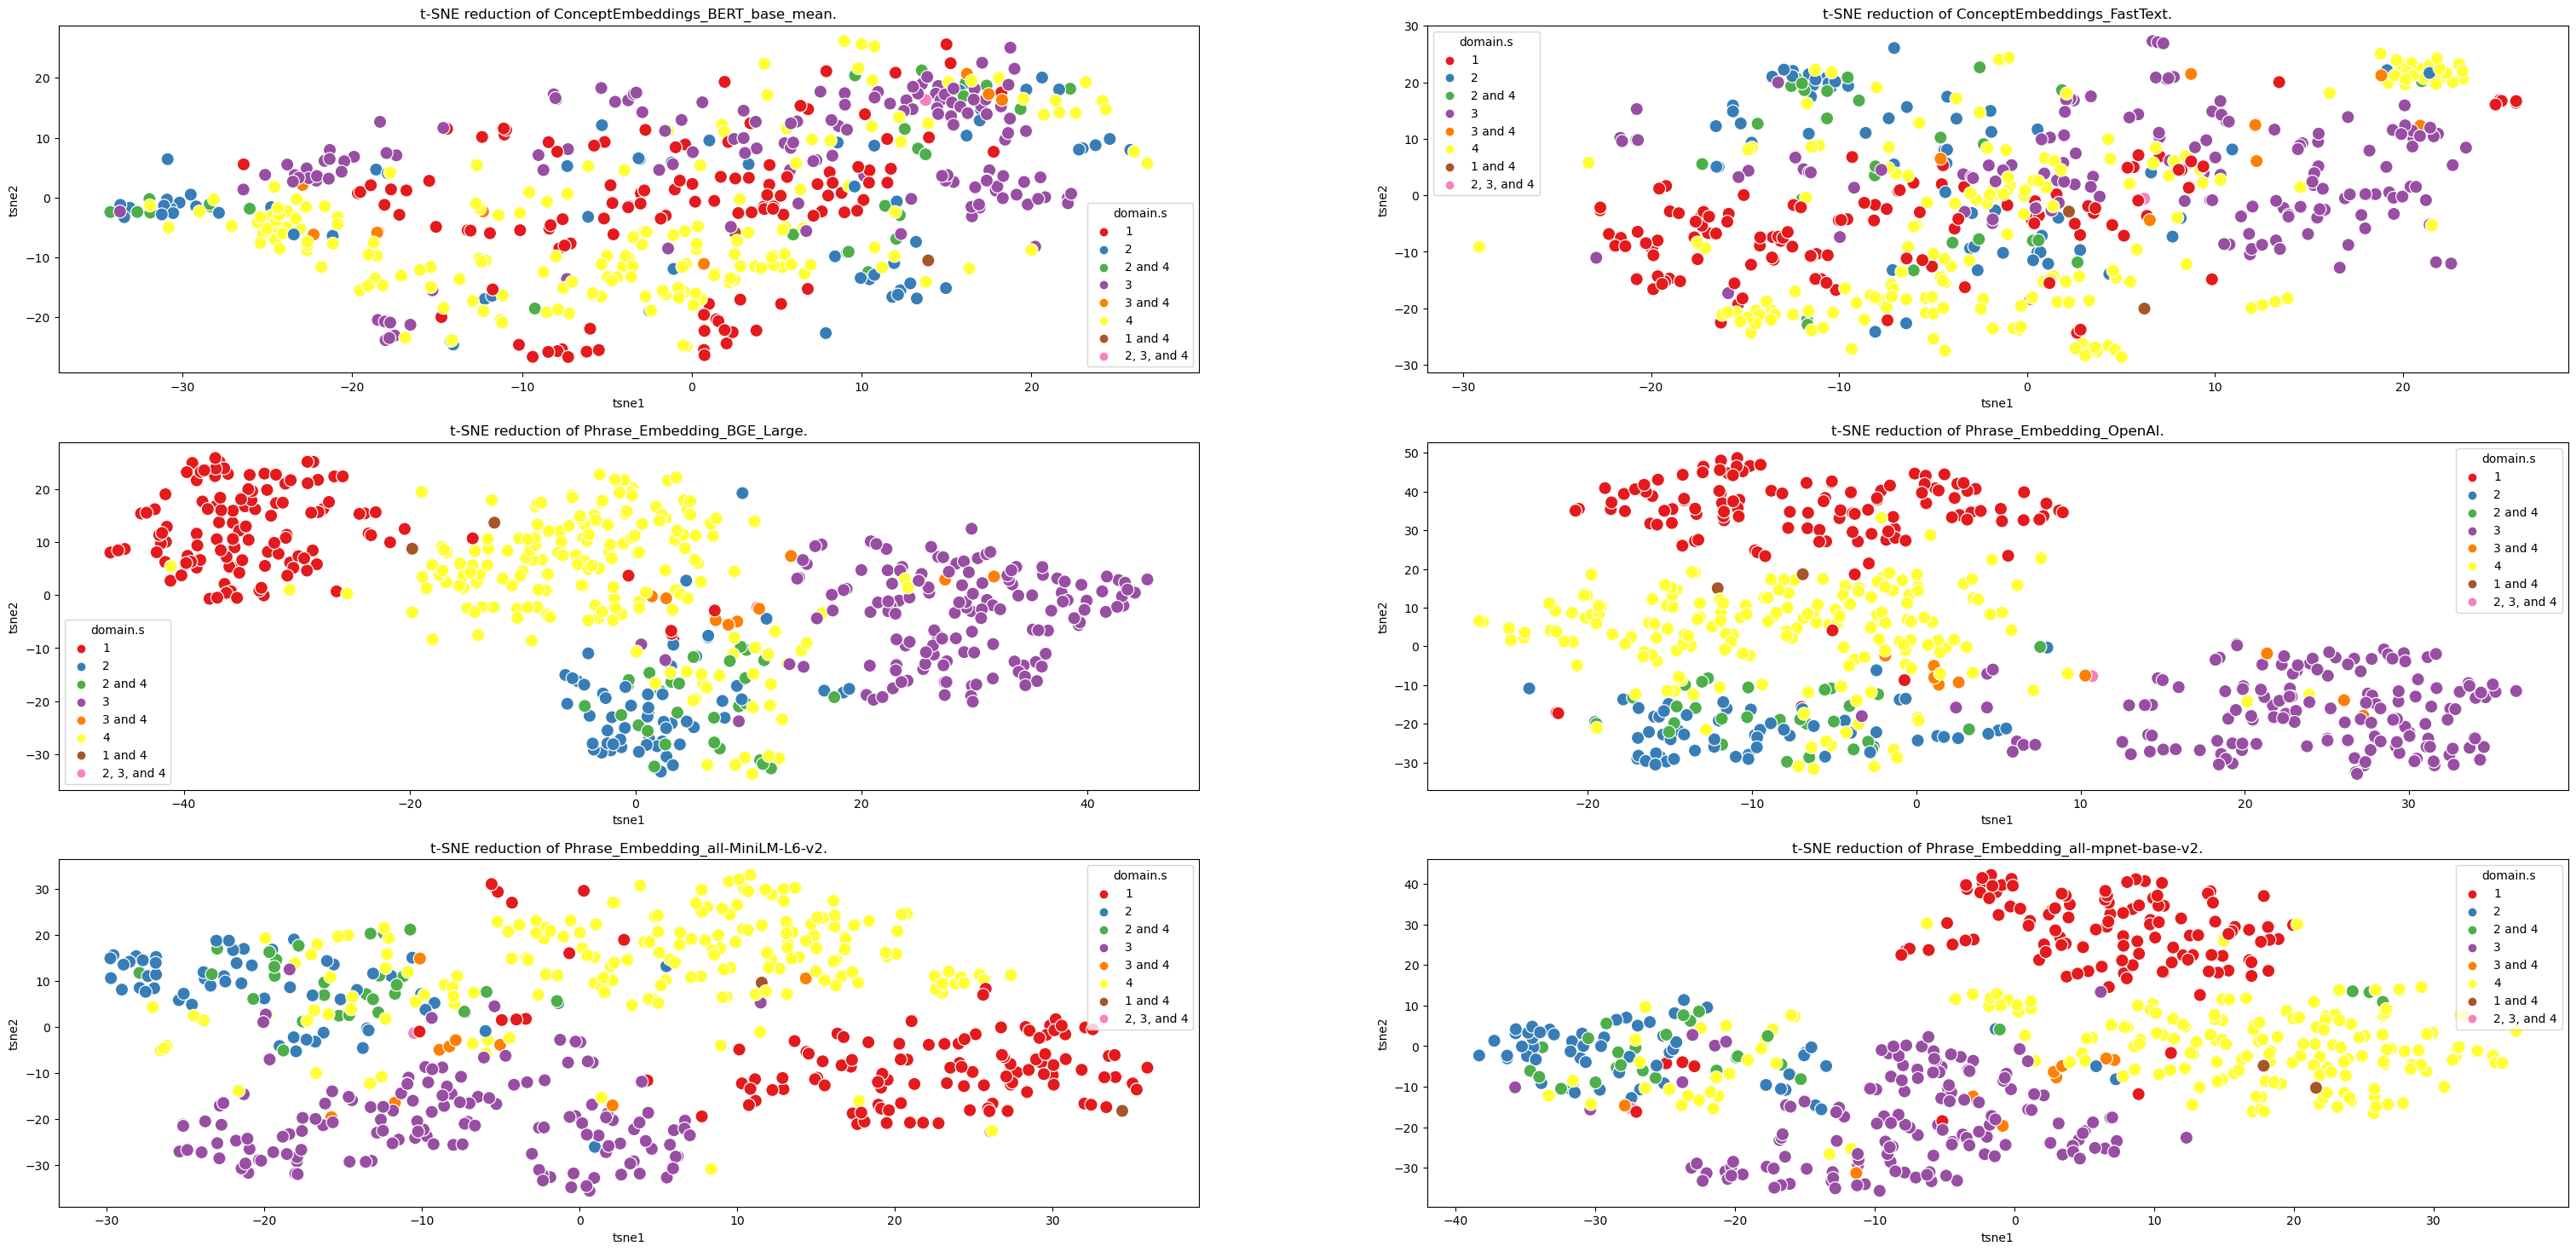

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

embeddings_displayed = ['ConceptEmbeddings_BERT_base_mean', 'ConceptEmbeddings_FastText',
                        'Phrase_Embedding_BGE_Large', 'Phrase_Embedding_OpenAI',
                        'Phrase_Embedding_all-MiniLM-L6-v2', 'Phrase_Embedding_all-mpnet-base-v2']

f, ax = plt.subplots(int(np.ceil(len(embeddings_displayed)/2)), 2, figsize=(38, 18))

for i, embed_type in enumerate(embeddings_displayed):
    X_og = wiki_data_df[embed_type].to_numpy()
    X_og = np.array([np.array(el) for el in X_og]).astype('float32')
    X_embedded = TSNE(n_components=2).fit_transform(X_og)
    df_subset = pd.DataFrame()
    df_subset['tsne1'] = X_embedded[:,0]
    df_subset['tsne2'] = X_embedded[:,1]
    ax[i//2,i%2].set_title("t-SNE reduction of {0}.".format(embed_type))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        palette="Set1",
        data=df_subset,
        hue=wiki_data_df['domain.s'],
        legend="full",
        s=120,
        ax=ax[i//2,i%2]
    )

f.savefig("Generated_Images/T-SNE_on_Generated_Embeddings.jpg")

**Note** that concepts can belong to multiple domains. For example, when a concept has a `domain.s` value of `2 and 4` it means that it belongs to the "Geomtry" and "Precalculus" domains at the same time according to our domain mapping `{"data_mining": 1, "geometry": 2, "physics": 3, "precalculus": 4}`.

## Metrics Computation

In [9]:
def Cosine_Scores(embeddings):
    embeddings = list(embeddings)
    cos_sim = cosine_similarity(embeddings, embeddings)
    for i in range (len(cos_sim)):
        cos_sim[i, i] = 0
    return cos_sim

In [10]:
def Compute_Metrics(concept_name, cosine_matrix, concerned_concepts, prerequisites, k_list = [1, 5, 10, 100]):
    idx = concerned_concepts[concerned_concepts.Concepts == concept_name].index
    cos_sim_list = cosine_matrix[idx][0]
    pred_names = prerequisites[prerequisites.Concept.isin([concept_name])].Prerequisite
    pred = concerned_concepts[concerned_concepts.Concepts.isin(pred_names)].index
    succ_names = prerequisites[prerequisites.Prerequisite.isin([concept_name])].Concept
    succ = concerned_concepts[concerned_concepts.Concepts.isin(succ_names)].index
    relevant_items = list(pred) + list(succ)
    
    results = [MRR(cos_sim_list, relevant_items)] + [precision_at_k(cos_sim_list, relevant_items, k=k) for k in k_list] 
    results += [recall_at_k(cos_sim_list, relevant_items, k=k) for k in k_list]
    return results

In [34]:
## Computing all metrics on embeddings
MRR_results = []
k_list = [1, 5, 10, 100]
precision_results = {k: [] for k in k_list}
recall_results = {k: [] for k in k_list}

for embed_type in embeddings_displayed:
    MRR_values = []
    for domain, concept_set in concepts_by_domain.items():
        prerequisites = prereqs_by_domain[domain]
        concepts_from_domain = wiki_data_df[wiki_data_df.Concepts.isin(concept_set)].reset_index()

        cosine_matrix = Cosine_Scores(concepts_from_domain[embed_type])

        concepts_from_domain_with_prereqs = concepts_from_domain[concepts_from_domain.Concepts.isin(pd.concat([prerequisites.Concept, prerequisites.Prerequisite]).unique())]
        
        values = concepts_from_domain_with_prereqs.apply(lambda x: Compute_Metrics(x.Concepts, cosine_matrix, concepts_from_domain, prerequisites, k_list), axis=1, result_type='expand').to_numpy().mean(axis=0)
        
        MRR_values.append(values[0])
        [precision_results[k].append(values[1+i]) for i, k in enumerate(k_list)]
        [recall_results[k].append(values[1+len(k_list)+i]) for i, k in enumerate(k_list)]

    MRR_results += [MRR_values]

precision_results = {key: np.array(value).reshape(len(embeddings_displayed),-1) for key, value in precision_results.items()}
recall_results = {key: np.array(value).reshape(len(embeddings_displayed),-1) for key, value in recall_results.items()}

#### Display Results

In [35]:
def PrettyTableforResults(results, embeddings_displayed, concepts_by_domain, metric_name='MRR'):
    results_df = pd.DataFrame(results, index=embeddings_displayed, columns=concepts_by_domain.keys())

    ## Computing regular average
    results_df['avg_{0}'.format(metric_name)] = results_df.mean(axis=1)

    ## Computing Weighted Average Based on the Number of Concepts per Domain
    num_concepts_per_domain   = np.array([len(concepts_set) for concepts_set in concepts_by_domain.values()])
    results_df['weighted_avg_{0}'.format(metric_name)] = (results_df.drop(columns='avg_{0}'.format(metric_name)) * num_concepts_per_domain / num_concepts_per_domain.sum()).sum(axis=1)

    ## Indexing Columns to Bring more Clarity to the Data Frame
    tuples = [('{0} per Domain'.format(metric_name), domain) for domain in concepts_by_domain.keys()] + [('Average {0} Across Domains'.format(metric_name), 'avg_{0}'.format(metric_name)), ('Average {0} Across Domains'.format(metric_name), 'weighted_avg_{0}'.format(metric_name))]
    results_df.columns = pd.MultiIndex.from_tuples(tuples)

    return results_df

In [36]:
PrettyTableforResults(MRR_results, embeddings_displayed, concepts_by_domain, metric_name='MRR')

MRR per Domain                      \
                                      data_mining  geometry   physics   
ConceptEmbeddings_BERT_base_mean         0.102322  0.087784  0.090470   
ConceptEmbeddings_FastText               0.126090  0.121251  0.135783   
Phrase_Embedding_BGE_Large               0.246206  0.191128  0.249199   
Phrase_Embedding_OpenAI                  0.233647  0.174938  0.228028   
Phrase_Embedding_all-MiniLM-L6-v2        0.240905  0.191222  0.265479   
Phrase_Embedding_all-mpnet-base-v2       0.237530  0.205310  0.260172   

                                               Average MRR Across Domains  \
                                   precalculus                    avg_MRR   
ConceptEmbeddings_BERT_base_mean      0.072648                   0.088306   
ConceptEmbeddings_FastText            0.096642                   0.119942   
Phrase_Embedding_BGE_Large            0.227209                   0.228436   
Phrase_Embedding_OpenAI               0.221853                   0.214617   
Phrase_Embedding_all-MiniLM-L6-v2     0.249195                   0.236700   
Phrase_Embedding_all-mpnet-base-v2    0.239575                   0.235647   

                                                     
                                   weighted_avg_MRR  
ConceptEmbeddings_BERT_base_mean           0.085677  
ConceptEmbeddings_FastText                 0.116629  
Phrase_Embedding_BGE_Large                 0.231361  
Phrase_Embedding_OpenAI                    0.218755  
Phrase_Embedding_all-MiniLM-L6-v2          0.242944  
Phrase_Embedding_all-mpnet-base-v2         0.239330

In [37]:
PrettyTableforResults(precision_results[1], embeddings_displayed, concepts_by_domain, metric_name='Precision_@1')

Precision_@1 per Domain            \
                                               data_mining  geometry   
ConceptEmbeddings_BERT_base_mean                  0.166667  0.306818   
ConceptEmbeddings_FastText                        0.244444  0.363636   
Phrase_Embedding_BGE_Large                        0.488889  0.556818   
Phrase_Embedding_OpenAI                           0.477778  0.625000   
Phrase_Embedding_all-MiniLM-L6-v2                 0.500000  0.579545   
Phrase_Embedding_all-mpnet-base-v2                0.477778  0.647727   

                                                          \
                                     physics precalculus   
ConceptEmbeddings_BERT_base_mean    0.177419    0.188776   
ConceptEmbeddings_FastText          0.250000    0.224490   
Phrase_Embedding_BGE_Large          0.524194    0.454082   
Phrase_Embedding_OpenAI             0.427419    0.464286   
Phrase_Embedding_all-MiniLM-L6-v2   0.564516    0.525510   
Phrase_Embedding_all-mpnet-base-v2  0.516129    0.505102   

                                   Average Precision_@1 Across Domains  \
                                                      avg_Precision_@1   
ConceptEmbeddings_BERT_base_mean                              0.209920   
ConceptEmbeddings_FastText                                    0.270643   
Phrase_Embedding_BGE_Large                                    0.505996   
Phrase_Embedding_OpenAI                                       0.498621   
Phrase_Embedding_all-MiniLM-L6-v2                             0.542393   
Phrase_Embedding_all-mpnet-base-v2                            0.536684   

                                                              
                                   weighted_avg_Precision_@1  
ConceptEmbeddings_BERT_base_mean                    0.199211  
ConceptEmbeddings_FastText                          0.256370  
Phrase_Embedding_BGE_Large                          0.495118  
Phrase_Embedding_OpenAI                             0.481832  
Phrase_Embedding_all-MiniLM-L6-v2                   0.538677  
Phrase_Embedding_all-mpnet-base-v2                  0.524047

In [38]:
PrettyTableforResults(precision_results[10], embeddings_displayed, concepts_by_domain, metric_name='Precision_@10')

Precision_@10 per Domain            \
                                                data_mining  geometry   
ConceptEmbeddings_BERT_base_mean                   0.125556  0.160227   
ConceptEmbeddings_FastText                         0.131111  0.213636   
Phrase_Embedding_BGE_Large                         0.213333  0.322727   
Phrase_Embedding_OpenAI                            0.210000  0.282955   
Phrase_Embedding_all-MiniLM-L6-v2                  0.243333  0.304545   
Phrase_Embedding_all-mpnet-base-v2                 0.238889  0.310227   

                                                          \
                                     physics precalculus   
ConceptEmbeddings_BERT_base_mean    0.096774    0.077041   
ConceptEmbeddings_FastText          0.137903    0.116837   
Phrase_Embedding_BGE_Large          0.266129    0.218878   
Phrase_Embedding_OpenAI             0.264516    0.220408   
Phrase_Embedding_all-MiniLM-L6-v2   0.287903    0.234694   
Phrase_Embedding_all-mpnet-base-v2  0.274194    0.234184   

                                   Average Precision_@10 Across Domains  \
                                                      avg_Precision_@10   
ConceptEmbeddings_BERT_base_mean                               0.114899   
ConceptEmbeddings_FastText                                     0.149872   
Phrase_Embedding_BGE_Large                                     0.255267   
Phrase_Embedding_OpenAI                                        0.244470   
Phrase_Embedding_all-MiniLM-L6-v2                              0.267619   
Phrase_Embedding_all-mpnet-base-v2                             0.264373   

                                                               
                                   weighted_avg_Precision_@10  
ConceptEmbeddings_BERT_base_mean                     0.104762  
ConceptEmbeddings_FastText                           0.139962  
Phrase_Embedding_BGE_Large                           0.245852  
Phrase_Embedding_OpenAI                              0.239292  
Phrase_Embedding_all-MiniLM-L6-v2                    0.260964  
Phrase_Embedding_all-mpnet-base-v2                   0.257143

In [39]:
PrettyTableforResults(recall_results[1], embeddings_displayed, concepts_by_domain, metric_name='Recall_@1')

Recall_@1 per Domain                      \
                                            data_mining  geometry   physics   
ConceptEmbeddings_BERT_base_mean               0.036865  0.035212  0.029727   
ConceptEmbeddings_FastText                     0.052395  0.052430  0.064411   
Phrase_Embedding_BGE_Large                     0.112174  0.087636  0.138772   
Phrase_Embedding_OpenAI                        0.110496  0.100324  0.108311   
Phrase_Embedding_all-MiniLM-L6-v2              0.121013  0.098965  0.151306   
Phrase_Embedding_all-mpnet-base-v2             0.110899  0.113615  0.144508   

                                                \
                                   precalculus   
ConceptEmbeddings_BERT_base_mean      0.032764   
ConceptEmbeddings_FastText            0.034007   
Phrase_Embedding_BGE_Large            0.117310   
Phrase_Embedding_OpenAI               0.106737   
Phrase_Embedding_all-MiniLM-L6-v2     0.132207   
Phrase_Embedding_all-mpnet-base-v2    0.124456   

                                   Average Recall_@1 Across Domains  \
                                                      avg_Recall_@1   
ConceptEmbeddings_BERT_base_mean                           0.033642   
ConceptEmbeddings_FastText                                 0.050811   
Phrase_Embedding_BGE_Large                                 0.113973   
Phrase_Embedding_OpenAI                                    0.106467   
Phrase_Embedding_all-MiniLM-L6-v2                          0.125873   
Phrase_Embedding_all-mpnet-base-v2                         0.123370   

                                                           
                                   weighted_avg_Recall_@1  
ConceptEmbeddings_BERT_base_mean                 0.033183  
ConceptEmbeddings_FastText                       0.048509  
Phrase_Embedding_BGE_Large                       0.117355  
Phrase_Embedding_OpenAI                          0.106944  
Phrase_Embedding_all-MiniLM-L6-v2                0.129853  
Phrase_Embedding_all-mpnet-base-v2               0.125269

In [40]:
PrettyTableforResults(recall_results[10], embeddings_displayed, concepts_by_domain, metric_name='Recall_@10')

Recall_@10 per Domain                      \
                                             data_mining  geometry   physics   
ConceptEmbeddings_BERT_base_mean                0.210889  0.160739  0.167565   
ConceptEmbeddings_FastText                      0.240929  0.233281  0.247538   
Phrase_Embedding_BGE_Large                      0.457012  0.398940  0.478606   
Phrase_Embedding_OpenAI                         0.462169  0.330366  0.477255   
Phrase_Embedding_all-MiniLM-L6-v2               0.502606  0.369299  0.512608   
Phrase_Embedding_all-mpnet-base-v2              0.482776  0.374245  0.487773   

                                                \
                                   precalculus   
ConceptEmbeddings_BERT_base_mean      0.130748   
ConceptEmbeddings_FastText            0.209192   
Phrase_Embedding_BGE_Large            0.443839   
Phrase_Embedding_OpenAI               0.448255   
Phrase_Embedding_all-MiniLM-L6-v2     0.486682   
Phrase_Embedding_all-mpnet-base-v2    0.486083   

                                   Average Recall_@10 Across Domains  \
                                                      avg_Recall_@10   
ConceptEmbeddings_BERT_base_mean                            0.167485   
ConceptEmbeddings_FastText                                  0.232735   
Phrase_Embedding_BGE_Large                                  0.444599   
Phrase_Embedding_OpenAI                                     0.429511   
Phrase_Embedding_all-MiniLM-L6-v2                           0.467799   
Phrase_Embedding_all-mpnet-base-v2                          0.457719   

                                                            
                                   weighted_avg_Recall_@10  
ConceptEmbeddings_BERT_base_mean                  0.161327  
ConceptEmbeddings_FastText                        0.229362  
Phrase_Embedding_BGE_Large                        0.448795  
Phrase_Embedding_OpenAI                           0.440771  
Phrase_Embedding_all-MiniLM-L6-v2                 0.478884  
Phrase_Embedding_all-mpnet-base-v2                0.468861

##### Observation
Embeddings generated using [Sentence Transformers](https://www.sbert.net/docs/pretrained_models.html) (`Phrase_Embedding_all-MiniLM-L6-v2` and `Phrase_Embedding_all-mpnet-base-v2`) outperform other embeddings according to every metric defined above.